<a href="https://colab.research.google.com/github/TanT246/Ecommerce-Customer-Behavior-Analysis/blob/main/MRI_Scan_All_Models_Current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install tensorflow
! pip install kagglehub
! pip install psutil
! pip install matplotlib

# MRI scans for Alzheimer

In [ ]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # to surpress the CUDA warnings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# check how many cp we are working with
print(f"Number of CPU cores available: {os.cpu_count()}")

Number of CPU cores available: 12


# Importinng Dataset

In [ ]:
# importing the data
import kagglehub

# download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 380M/380M [00:01<00:00, 252MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1


# Splitting the Dataset into Training and Testing Set

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision training
set_global_policy('mixed_float16')

# Enable XLA for faster computations
tf.config.optimizer.set_jit(True)

# Paths to datasets
original_dir = os.path.join(path, 'OriginalDataset')
augmented_dir = os.path.join(path, 'AugmentedAlzheimerDataset')

# Preprocess function without batching immediately
def preprocess_dataset(dataset, img_size=(224, 224)):
    def resize_and_normalize(image, label):
        image = tf.image.resize(image, img_size)
        image = image / 255.0  # Normalize pixel values
        return image, label

    return dataset.map(resize_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)

# Function for 70-15-15 train-val-test split
def load_data_with_3way_split(directory, img_size=(224, 224), seed=123):
    total_dataset = image_dataset_from_directory(
        directory,
        labels='inferred',
        label_mode='int',
        image_size=img_size,
        batch_size=None,  # Process each image separately
        shuffle=True,
        seed=seed
    )

    # Total dataset size
    total_size = tf.data.experimental.cardinality(total_dataset).numpy()
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size

    # Debug: Check sizes before split
    print(f"Total dataset size: {total_size}, Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}")

    # Split datasets
    train_dataset = total_dataset.take(train_size)
    val_dataset = total_dataset.skip(train_size).take(val_size)
    test_dataset = total_dataset.skip(train_size + val_size)

    return (preprocess_dataset(train_dataset, img_size),
            preprocess_dataset(val_dataset, img_size),
            preprocess_dataset(test_dataset, img_size),
            total_dataset.class_names)

# Load original and augmented datasets with 3-way split
original_train, original_val, original_test, class_names_original = load_data_with_3way_split(original_dir)
augmented_train, augmented_val, augmented_test, class_names_augmented = load_data_with_3way_split(augmented_dir)

# Combine train, val, and test datasets from original and augmented
combined_train = original_train.concatenate(augmented_train)
combined_val = original_val.concatenate(augmented_val)
combined_test = original_test.concatenate(augmented_test)

# Verify total images before batching
print(f"Total Train Images BEFORE batching: {tf.data.experimental.cardinality(combined_train).numpy()} images")
print(f"Total Validation Images BEFORE batching: {tf.data.experimental.cardinality(combined_val).numpy()} images")
print(f"Total Test Images BEFORE batching: {tf.data.experimental.cardinality(combined_test).numpy()} images")

# Apply batching and prefetching
batch_size = 32
train_dataset = combined_train.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = combined_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = combined_test.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Verify total batches after batching
print(f"Total Train Batches AFTER batching: {tf.data.experimental.cardinality(train_dataset).numpy()} batches")
print(f"Total Validation Batches AFTER batching: {tf.data.experimental.cardinality(val_dataset).numpy()} batches")
print(f"Total Test Batches AFTER batching: {tf.data.experimental.cardinality(test_dataset).numpy()} batches")

# For debugging, calculate the total number of images after batching
total_train_images = tf.data.experimental.cardinality(train_dataset).numpy() * batch_size
total_val_images = tf.data.experimental.cardinality(val_dataset).numpy() * batch_size
total_test_images = tf.data.experimental.cardinality(test_dataset).numpy() * batch_size
print(f"Approx. Total Train Images: {total_train_images}")
print(f"Approx. Total Validation Images: {total_val_images}")
print(f"Approx. Total Test Images: {total_test_images}")


Found 6400 files belonging to 4 classes.
Total dataset size: 6400, Train size: 4480, Validation size: 960, Test size: 960
Found 33984 files belonging to 4 classes.
Total dataset size: 33984, Train size: 23788, Validation size: 5097, Test size: 5099
Total Train Images BEFORE batching: 28268 images
Total Validation Images BEFORE batching: 6057 images
Total Test Images BEFORE batching: 6059 images
Total Train Batches AFTER batching: 884 batches
Total Validation Batches AFTER batching: 190 batches
Total Test Batches AFTER batching: 190 batches
Approx. Total Train Images: 28288
Approx. Total Validation Images: 6080
Approx. Total Test Images: 6080


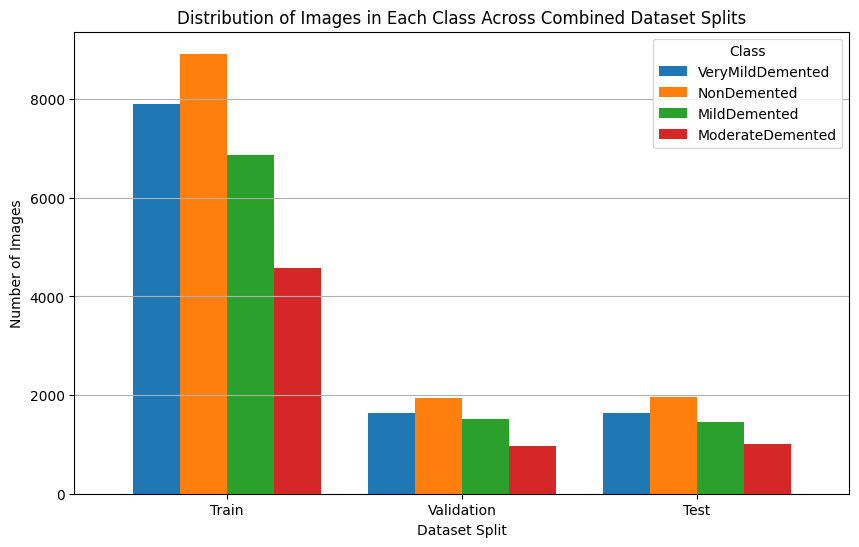

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Function to count images in each class from a batched dataset
def count_images_in_batched_dataset(dataset, class_names):
    class_counts = Counter()
    for _, labels in dataset:  # No unbatch, process labels directly from batches
        class_counts.update(labels.numpy())
    return {class_names[class_idx]: count for class_idx, count in class_counts.items()}

# Count images in each class for combined train, validation, and test datasets
train_combined_counts = count_images_in_batched_dataset(train_dataset, class_names_original)
val_combined_counts = count_images_in_batched_dataset(val_dataset, class_names_original)
test_combined_counts = count_images_in_batched_dataset(test_dataset, class_names_original)

# Combine counts into a DataFrame
data_counts = pd.DataFrame({
    'Train': train_combined_counts,
    'Validation': val_combined_counts,
    'Test': test_combined_counts
}).transpose()

# Plot the bar chart
data_counts.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title("Distribution of Images in Each Class Across Combined Dataset Splits")
plt.ylabel("Number of Images")
plt.xlabel("Dataset Split")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.grid(axis='y')
plt.show()


# Plotting the Images

Sample images from Original Dataset (Train):


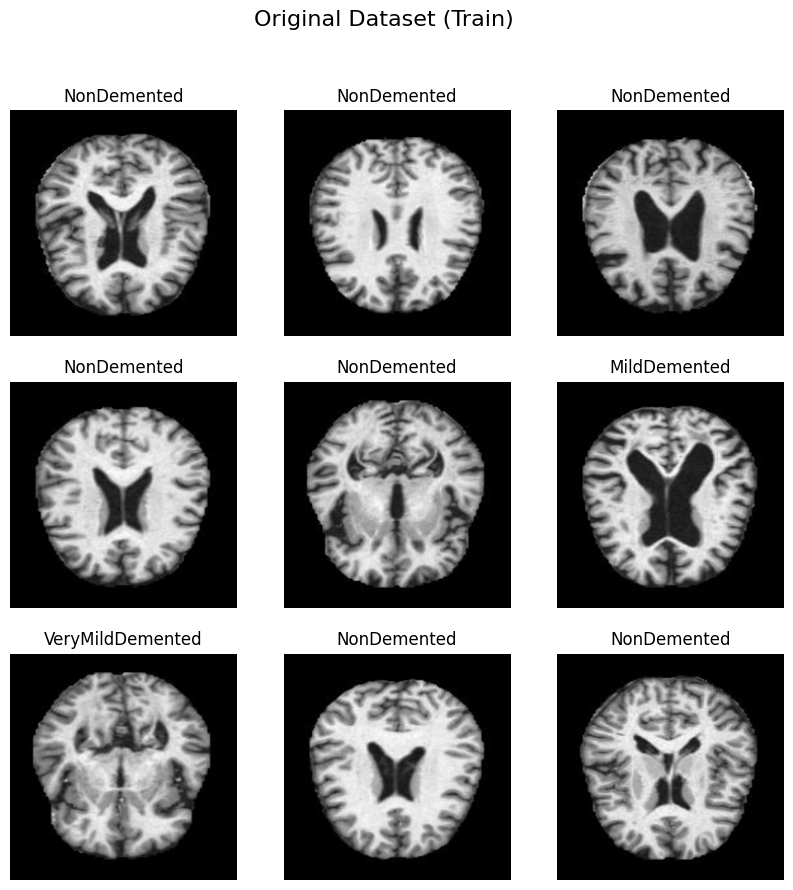

Sample images from Augmented Dataset (Train):


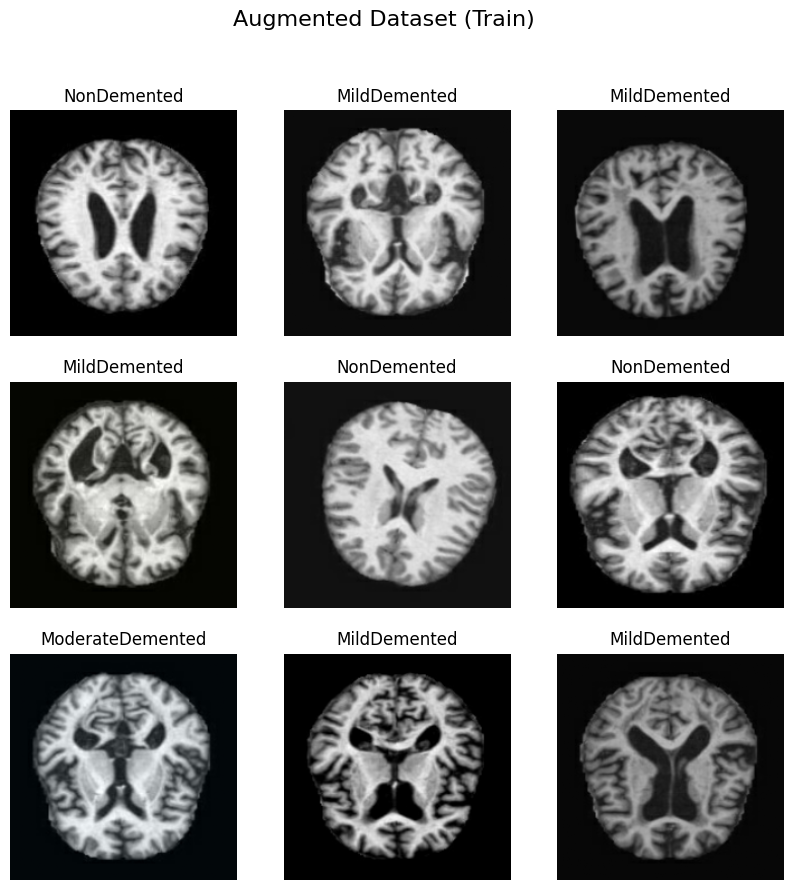

Sample images from Original Dataset (Validation):


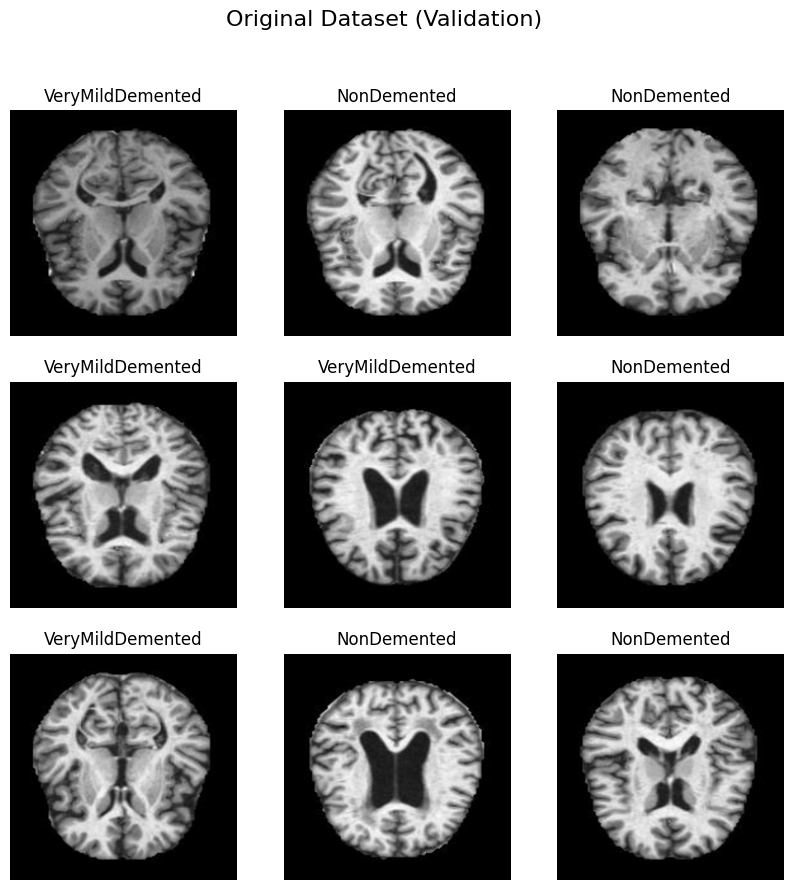

Sample images from Augmented Dataset (Validation):


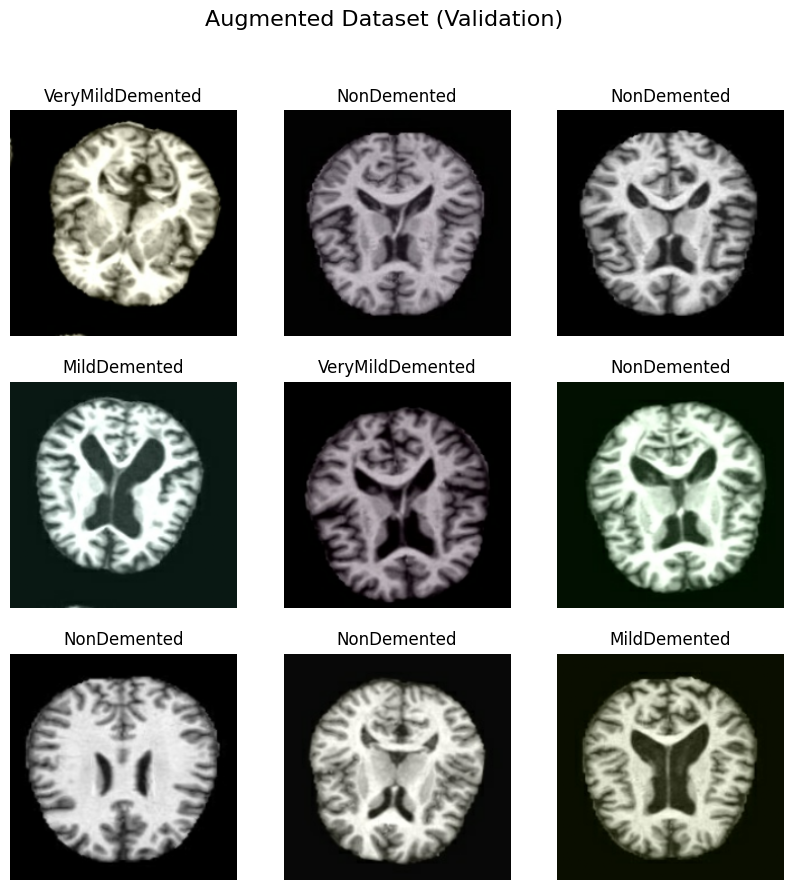

Sample images from Original Dataset (Testing):


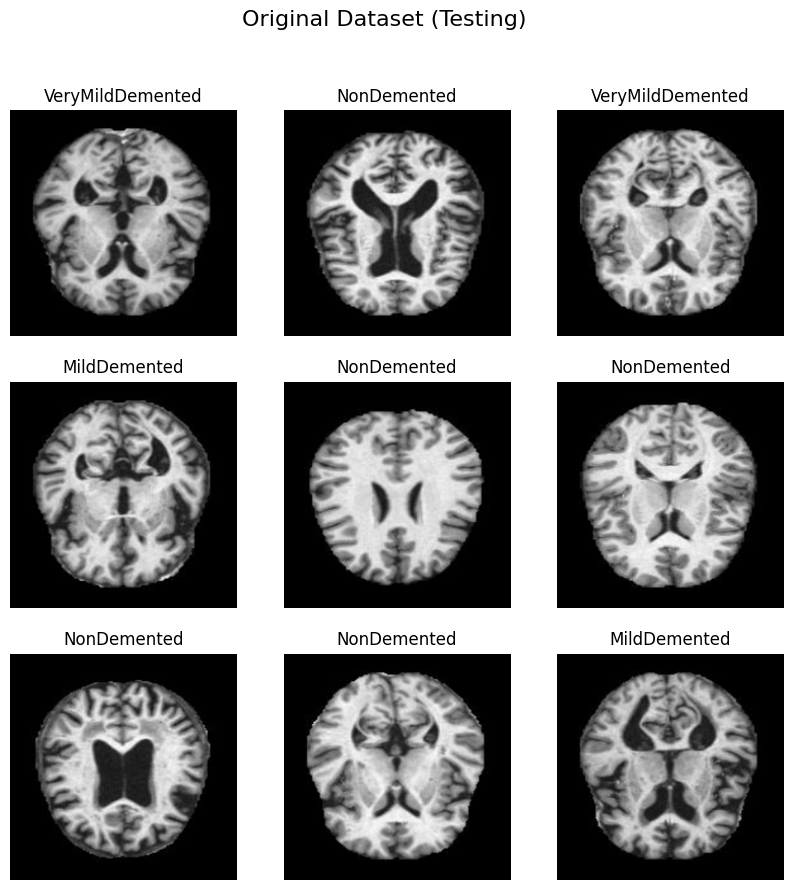

Sample images from Augmented Dataset (Testing):


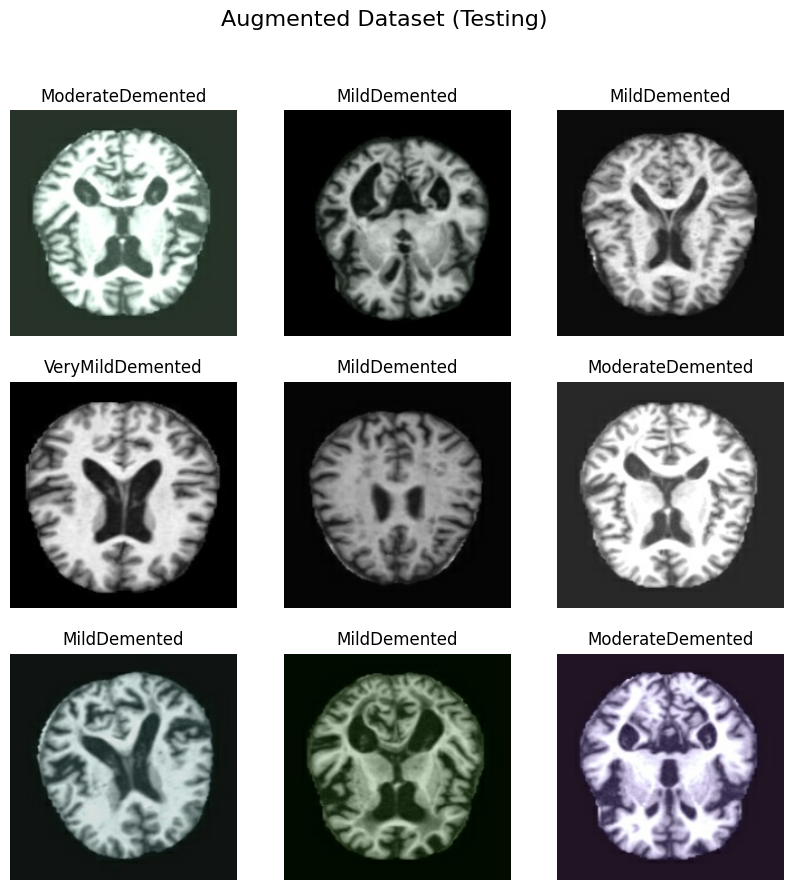

In [ ]:
import matplotlib.pyplot as plt

# Function to display sample images from a dataset
def display_sample_images(dataset, class_names, num_images=9, title="Sample Images"):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy())  # Convert Tensor to NumPy for display
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

# Display some original dataset images (Train)
print("Sample images from Original Dataset (Train):")
display_sample_images(original_train, class_names_original, title="Original Dataset (Train)")

# Display some augmented dataset images (Train)
print("Sample images from Augmented Dataset (Train):")
display_sample_images(augmented_train, class_names_augmented, title="Augmented Dataset (Train)")

# Display validation images
print("Sample images from Original Dataset (Validation):")
display_sample_images(original_val, class_names_original, title="Original Dataset (Validation)")

print("Sample images from Augmented Dataset (Validation):")
display_sample_images(augmented_val, class_names_augmented, title="Augmented Dataset (Validation)")

# Display testing images
print("Sample images from Original Dataset (Testing):")
display_sample_images(original_test, class_names_original, title="Original Dataset (Testing)")

print("Sample images from Augmented Dataset (Testing):")
display_sample_images(augmented_test, class_names_augmented, title="Augmented Dataset (Testing)")


# Building MobileNet Model


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization


# Define the MobileNet model
def create_mobilenet_model(input_shape=(224, 224, 3), num_classes=4):
    base_model = MobileNet(
        input_shape=input_shape,
        include_top=False,  # Exclude the fully connected layer
        weights='imagenet'  # Use ImageNet pre-trained weights
    )

    # Unfreeze the base model
    base_model.trainable = True

    # Add custom classification layers
    from tensorflow.keras.regularizers import l2

    # Add L2 regularization to dense layers
    model = Sequential([
      base_model,
      GlobalAveragePooling2D(),
      Dense(1024, activation='relu'),  # Increased dense layer size
      BatchNormalization(),
      Dropout(0.4),  # Increased dropout
      Dense(512, activation='relu'),
      Dropout(0.3),
      Dense(256, activation='relu'),
      Dropout(0.2),
      Dense(4, activation='softmax')
    ])

    return model

# Dynamic rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

# Create and compile the model
model = create_mobilenet_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Use sparse if labels are integers
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional)      │ (None, 7, 7, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1024)                │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,939,716 (18.84 MB)

 Trainable params: 4,915,780 (18.75 MB)

 Non-trainable params: 23,936 (93.50 KB)

# Training the model

In [ ]:
# Define callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 89s 61ms/step - accuracy: 0.5756 - loss: 1.0374 - val_accuracy: 0.8336 - val_loss: 0.3949 - learning_rate: 1.0000e-04
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8499 - loss: 0.3777 - val_accuracy: 0.9444 - val_loss: 0.1443 - learning_rate: 1.0000e-04
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9525 - loss: 0.1303 - val_accuracy: 0.8702 - val_loss: 0.4483 - learning_rate: 1.0000e-04
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9746 - loss: 0.0765 - val_accuracy: 0.9762 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.9809 - loss: 0.0547 - val_accuracy: 0.9491 - val_loss: 0.1491 - learning_rate: 1.0000e-04
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9841 - loss: 0.0455 - val_accuracy: 0.9794 - val_loss: 0.0540 - learning_rate: 1.0000e-04
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/ste

# Visualizing Training **History**

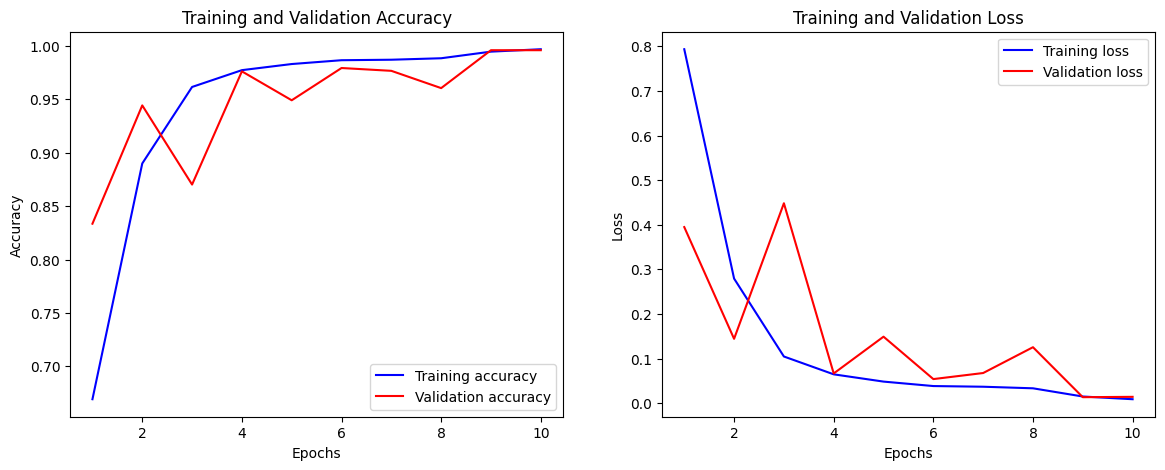

In [ ]:
# Plotting training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

# Generate Predictions

Evaluating model on the test set:
190/190 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step
Test Accuracy: 99.21%


<Figure size 1000x800 with 0 Axes>

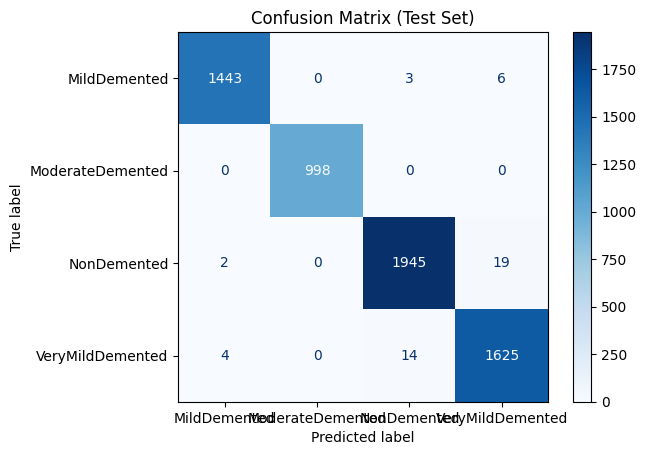

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      0.99      0.99      1452
ModerateDemented       1.00      1.00      1.00       998
     NonDemented       0.99      0.99      0.99      1966
VeryMildDemented       0.98      0.99      0.99      1643

        accuracy                           0.99      6059
       macro avg       0.99      0.99      0.99      6059
    weighted avg       0.99      0.99      0.99      6059



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# Generate predictions on the test dataset
def evaluate_model_on_test(model, test_dataset, class_names):
    # Unbatch the test dataset to get all individual images and labels
    test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # Generate predictions
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate test accuracy
    test_accuracy = accuracy_score(test_labels, predicted_classes)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(test_labels, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

    # Print classification report
    report = classification_report(test_labels, predicted_classes, target_names=class_names)
    print("Classification Report:\n")
    print(report)

    return predicted_classes

# Call the function to evaluate and display results on the test set
print("Evaluating model on the test set:")
predicted_classes = evaluate_model_on_test(model, test_dataset, class_names_original)


# CNN Model

In [ ]:
from tensorflow.keras import layers, models

# Build the Basic CNN Model
print("\nTraining Model 1: Basic CNN")
model_1 = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names_original), activation='softmax')  # Adjusted for the number of classes
])

# Compile the model
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_1 = model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)



Training Model 1: Basic CNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5546 - loss: 0.9711 - val_accuracy: 0.7647 - val_loss: 0.5439
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.7992 - loss: 0.4694 - val_accuracy: 0.8702 - val_loss: 0.3325
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9145 - loss: 0.2177 - val_accuracy: 0.9075 - val_loss: 0.2362
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9479 - loss: 0.1355 - val_accuracy: 0.9176 - val_loss: 0.2170
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9664 - loss: 0.0909 - val_accuracy: 0.9099 - val_loss: 0.2322
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9734 - loss: 0.0724 - val_accuracy: 0.9269 - val_loss: 0.2199
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9796 - loss: 0.0551 - val_accuracy: 0.9353 - val_loss: 0.2071
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9786 - loss: 0.0575 - 

In [ ]:
model_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,156,338 (27.30 MB)

 Trainable params: 2,385,444 (9.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,770,894 (18.20 MB)

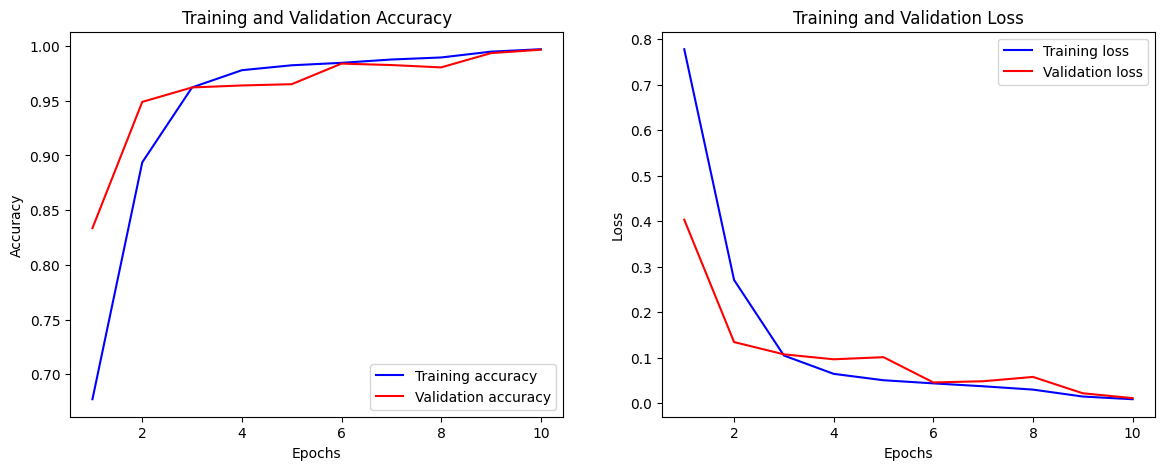

In [ ]:
# Plotting training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history)

190/190 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9439 - loss: 0.1896

Test Accuracy: 91.60%
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


<Figure size 1000x800 with 0 Axes>

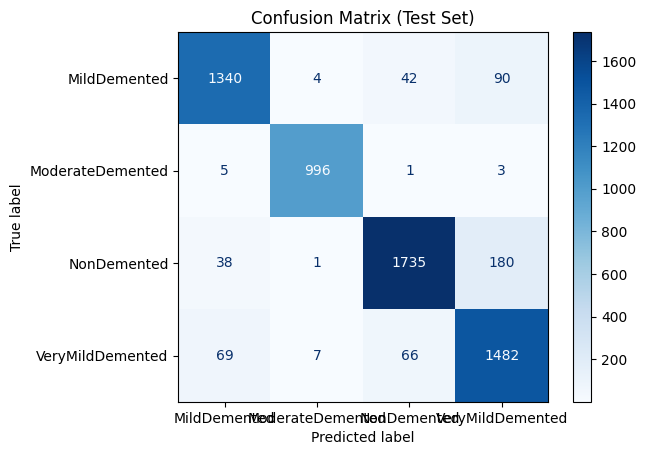


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.92      0.91      0.92      1476
ModerateDemented       0.99      0.99      0.99      1005
     NonDemented       0.94      0.89      0.91      1954
VeryMildDemented       0.84      0.91      0.88      1624

        accuracy                           0.92      6059
       macro avg       0.92      0.92      0.92      6059
    weighted avg       0.92      0.92      0.92      6059



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate on test dataset
test_loss, test_accuracy = model_1.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model_1.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)


# CNN + L2 Regularization lr = 0.01

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers

# CNN + L2 Regularization Model
print("\nTraining Model 2: CNN + L2 Regularization")

model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names_original), activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Training Model 2: CNN + L2 Regularization
Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5210 - loss: 4.1941 - val_accuracy: 0.4766 - val_loss: 3.8454
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6231 - loss: 2.7849 - val_accuracy: 0.3667 - val_loss: 3.3881
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6662 - loss: 2.5544 - val_accuracy: 0.2075 - val_loss: 7.7682
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6810 - loss: 2.4658 - val_accuracy: 0.6713 - val_loss: 1.7977
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6965 - loss: 2.5799 - val_accuracy: 0.4672 - val_loss: 2.6769
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7253 - loss: 1.9974 - val_accuracy: 0.4793 - val_loss: 2.2643
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7635 - loss: 1.5489 - val_accuracy: 0.4096 - val_loss: 3.1613
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17m

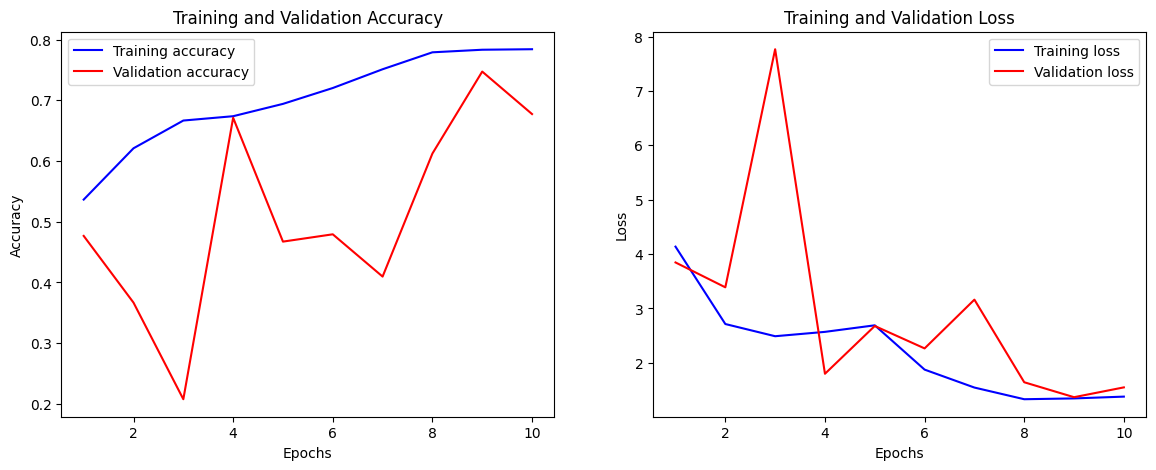

In [ ]:
# Plotting training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_training_history(history_2)

190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6524 - loss: 1.6144

Test Accuracy: 66.23%
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


<Figure size 1000x800 with 0 Axes>

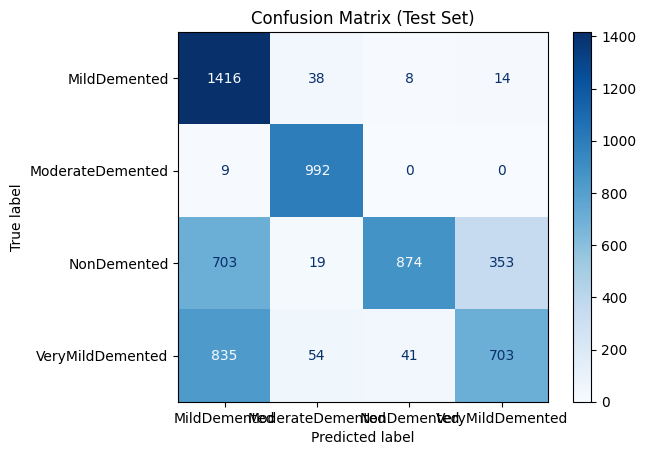


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.48      0.96      0.64      1476
ModerateDemented       0.90      0.99      0.94      1001
     NonDemented       0.95      0.45      0.61      1949
VeryMildDemented       0.66      0.43      0.52      1633

        accuracy                           0.66      6059
       macro avg       0.75      0.71      0.68      6059
    weighted avg       0.75      0.66      0.65      6059



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate on test dataset
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
# Convert the batched dataset to individual arrays for images and labels
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict class probabilities and convert to predicted classes
predictions = model_2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

# CNN with L2 Regularization with lr = 0.001

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.mixed_precision import set_global_policy

# CNN + L2 Regularization Model
print("\nTraining Model 2: CNN + L2 Regularization (0.001)")

model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names_original), activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Training Model 2: CNN + L2 Regularization (0.001)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


884/884 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - accuracy: 0.5700 - loss: 1.7553 - val_accuracy: 0.3193 - val_loss: 5.2821
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7870 - loss: 1.2158 - val_accuracy: 0.7900 - val_loss: 1.2144
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8375 - loss: 1.1660 - val_accuracy: 0.8072 - val_loss: 1.2669
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8382 - loss: 1.4371 - val_accuracy: 0.7869 - val_loss: 1.5912
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8724 - loss: 1.3052 - val_accuracy: 0.7253 - val_loss: 1.5893
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8933 - loss: 1.1019 - val_accuracy: 0.8321 - val_loss: 1.2218
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8976 - loss: 1.0375 - val_accuracy: 0.4714 - val_loss: 2.7013
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9102 - loss: 0.9528 - val_accurac

190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8935 - loss: 0.9176

Test Accuracy: 86.14%
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


<Figure size 1000x800 with 0 Axes>

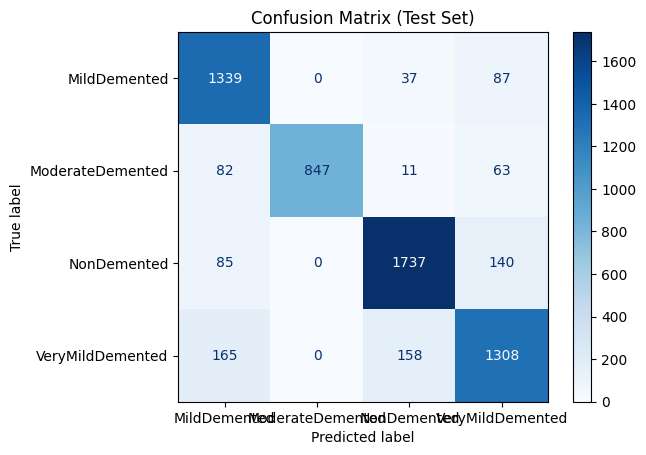


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.80      0.92      0.85      1463
ModerateDemented       1.00      0.84      0.92      1003
     NonDemented       0.89      0.89      0.89      1962
VeryMildDemented       0.82      0.80      0.81      1631

        accuracy                           0.86      6059
       macro avg       0.88      0.86      0.87      6059
    weighted avg       0.87      0.86      0.86      6059



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate on test dataset
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
# Convert the batched dataset to individual arrays for images and labels
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict class probabilities and convert to predicted classes
predictions = model_2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

# CNN with L2 Regularization with lr = 0.0001

In [ ]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.mixed_precision import set_global_policy

# CNN + L2 Regularization Model
print("\nTraining Model 2: CNN + L2 Regularization (0.0001)")

model_2 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001), input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names_original), activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_2 = model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Training Model 2: CNN + L2 Regularization (0.0001)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


884/884 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.5605 - loss: 1.2290 - val_accuracy: 0.1737 - val_loss: 11.9146
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7961 - loss: 0.7222 - val_accuracy: 0.8121 - val_loss: 0.7142
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8391 - loss: 0.7329 - val_accuracy: 0.8483 - val_loss: 0.7650
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8815 - loss: 0.6849 - val_accuracy: 0.3607 - val_loss: 3.1454
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9020 - loss: 0.6630 - val_accuracy: 0.7803 - val_loss: 0.9575
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9248 - loss: 0.5715 - val_accuracy: 0.6931 - val_loss: 2.8619
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9446 - loss: 0.5239 - val_accuracy: 0.8631 - val_loss: 0.7285
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9192 - loss: 0.5949 - val_accura

Exploding Gradient caused a drop in accuracy

190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8684 - loss: 0.8763

Test Accuracy: 82.34%
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


<Figure size 1000x800 with 0 Axes>

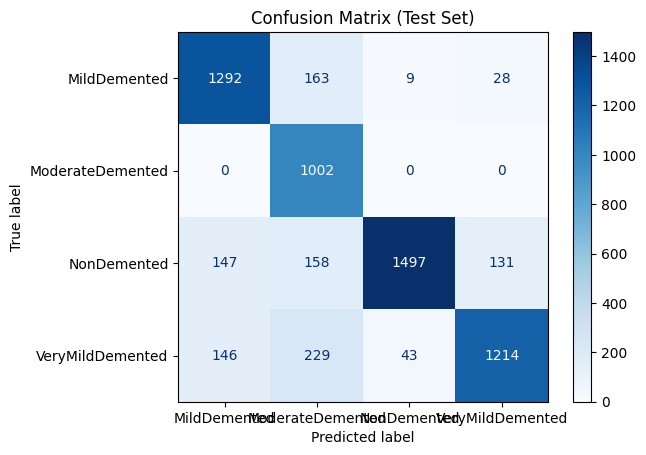


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.82      0.87      0.84      1492
ModerateDemented       0.65      1.00      0.78      1002
     NonDemented       0.97      0.77      0.86      1933
VeryMildDemented       0.88      0.74      0.81      1632

        accuracy                           0.83      6059
       macro avg       0.83      0.85      0.82      6059
    weighted avg       0.85      0.83      0.83      6059



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate on test dataset
test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
# Convert the batched dataset to individual arrays for images and labels
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict class probabilities and convert to predicted classes
predictions = model_2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)



# CNN with Batch Normalizations

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model 3: CNN + BatchNormalization
print("\nTraining Model 3: CNN + BatchNormalization")
model_3 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names_original), activation='softmax')
])

# Compile the model
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_3 = model_3.fit(train_dataset, validation_data=val_dataset, epochs=10)



Training Model 3: CNN + BatchNormalization
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


884/884 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - accuracy: 0.5898 - loss: 1.0921 - val_accuracy: 0.8058 - val_loss: 0.5426
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8088 - loss: 0.5188 - val_accuracy: 0.8613 - val_loss: 0.3934
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8869 - loss: 0.3169 - val_accuracy: 0.8522 - val_loss: 0.4132
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9267 - loss: 0.2114 - val_accuracy: 0.9014 - val_loss: 0.2775
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9471 - loss: 0.1557 - val_accuracy: 0.8887 - val_loss: 0.3383
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9602 - loss: 0.1138 - val_accuracy: 0.8938 - val_loss: 0.3739
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9643 - loss: 0.1015 - val_accuracy: 0.8945 - val_loss: 0.4056
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9745 - loss: 0.0742 - val_accurac

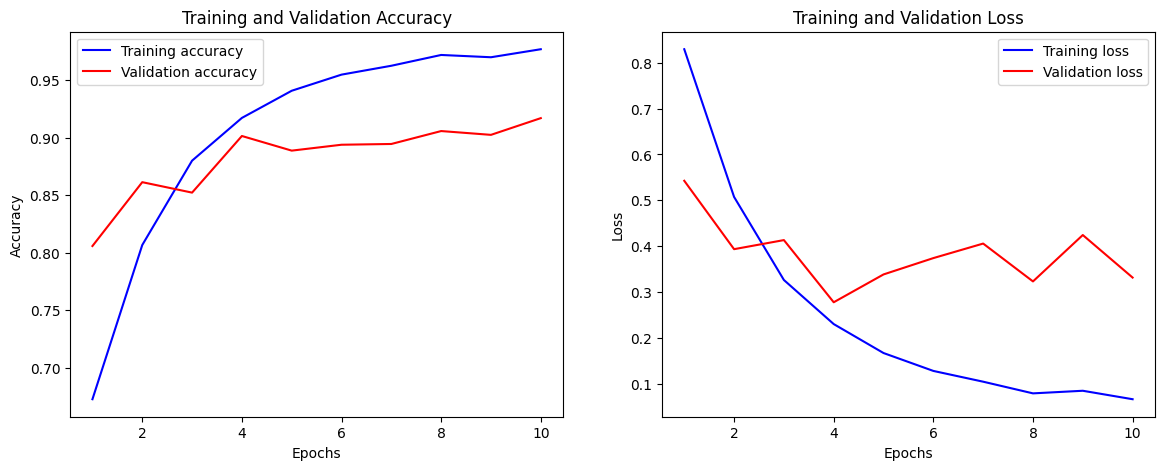

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history_3)

190/190 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9331 - loss: 0.2626

Test Accuracy: 90.10%
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


<Figure size 1000x800 with 0 Axes>

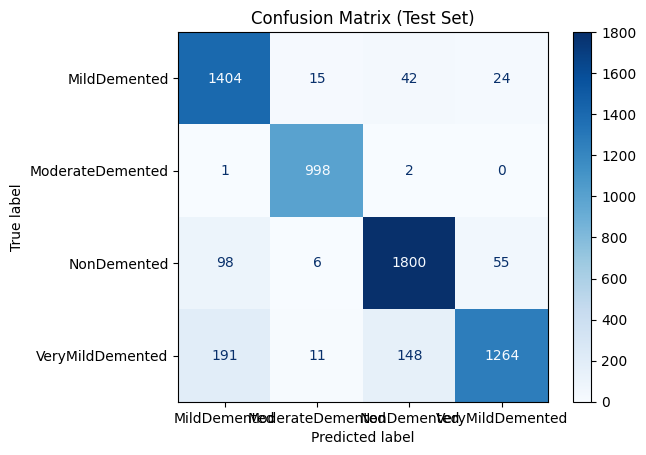


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.83      0.95      0.88      1485
ModerateDemented       0.97      1.00      0.98      1001
     NonDemented       0.90      0.92      0.91      1959
VeryMildDemented       0.94      0.78      0.85      1614

        accuracy                           0.90      6059
       macro avg       0.91      0.91      0.91      6059
    weighted avg       0.91      0.90      0.90      6059



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Evaluate on test dataset
test_loss, test_accuracy = model_3.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
# Convert the batched dataset to individual arrays for images and labels
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Predict class probabilities and convert to predicted classes
predictions = model_3.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)


# ConvNeXt Model

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.mixed_precision import set_global_policy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt


# Build the ConvNeXt model
print("\nTraining Model: ConvNeXt")
base_model_4 = ConvNeXtTiny(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model_4.trainable = False

model_4 = models.Sequential([
    base_model_4,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names_original), activation='softmax')
])

# Compile the model
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)



Training Model: ConvNeXt
Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.4382 - loss: 1.1990 - val_accuracy: 0.5169 - val_loss: 1.0612
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5382 - loss: 1.0004 - val_accuracy: 0.5734 - val_loss: 0.9761
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5650 - loss: 0.9472 - val_accuracy: 0.5767 - val_loss: 0.9279
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5822 - loss: 0.8978 - val_accuracy: 0.5957 - val_loss: 0.8865
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5894 - loss: 0.8860 - val_accuracy: 0.5911 - val_loss: 0.8763
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5972 - loss: 0.8649 - val_accuracy: 0.6198 - val_loss: 0.8451
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6112 - loss: 0.8366 - val_accuracy: 0.6173 - val_loss: 0.8480
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy

In [ ]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_tiny (Functional)           │ (None, 7, 7, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,007,474 (110.65 MB)

 Trainable params: 395,780 (1.51 MB)

 Non-trainable params: 27,820,128 (106.13 MB)

 Optimizer params: 791,566 (3.02 MB)

190/190 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.6327 - loss: 0.8020

Test Accuracy: 64.91%
190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


<Figure size 1000x800 with 0 Axes>

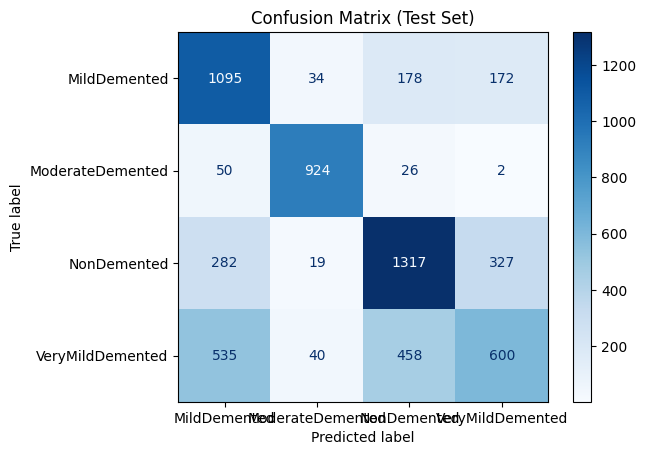


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.56      0.74      0.64      1479
ModerateDemented       0.91      0.92      0.92      1002
     NonDemented       0.67      0.68      0.67      1945
VeryMildDemented       0.54      0.37      0.44      1633

        accuracy                           0.65      6059
       macro avg       0.67      0.68      0.67      6059
    weighted avg       0.65      0.65      0.64      6059



In [ ]:
# Evaluate on test dataset
test_loss, test_accuracy = model_4.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions on the test dataset
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model_2.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

# CNN with ReduceLROnPlateau

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models

# Model 7: CNN + ReduceLROnPlateau
print("\nTraining Model 7: CNN + ReduceLROnPlateau")
model_7 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(len(class_names_original), activation='softmax')
])

# Compile the model
model_7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ReduceLROnPlateau Callback
reduce_lr_7 = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history_7 = model_7.fit(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[reduce_lr_7])



Training Model 7: CNN + ReduceLROnPlateau
Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.4882 - loss: 1.2795 - val_accuracy: 0.5767 - val_loss: 0.8702 - learning_rate: 0.0010
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.7451 - loss: 0.6573 - val_accuracy: 0.7099 - val_loss: 0.7593 - learning_rate: 0.0010
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8448 - loss: 0.4269 - val_accuracy: 0.7685 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8943 - loss: 0.3026 - val_accuracy: 0.7745 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9228 - loss: 0.2320 - val_accuracy: 0.8749 - val_loss: 0.3799 - learning_rate: 0.0010
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9394 - loss: 0.1770 - val_accuracy: 0.8545 - val_loss: 0.4552 - learning_rate: 0.0010
Epoch 7/10
884/884 ━━━━━━━━━━━━━━

190/190 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9070 - loss: 0.3337

Test Accuracy: 86.55%
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


<Figure size 1000x800 with 0 Axes>

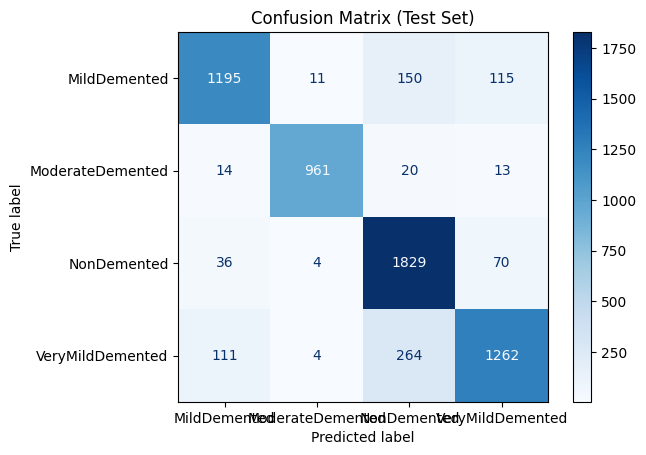


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.88      0.81      0.85      1471
ModerateDemented       0.98      0.95      0.97      1008
     NonDemented       0.81      0.94      0.87      1939
VeryMildDemented       0.86      0.77      0.81      1641

        accuracy                           0.87      6059
       macro avg       0.88      0.87      0.87      6059
    weighted avg       0.87      0.87      0.87      6059



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Evaluate on test dataset
test_loss, test_accuracy = model_7.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")

# Generate predictions
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model_7.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

# ResNet101 Model

In [ ]:
from tensorflow.keras.applications import ResNet101

# Model: Pre-trained ResNet101
print("\nTraining Model: Pre-trained ResNet101")

# Load the pre-trained ResNet101 model without the top classification layer
base_model_101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
base_model_101.trainable = True

# Build the custom model
model_resnet101 = models.Sequential([
    base_model_101,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names_original), activation='softmax')  # Output layer for 4 classes
])

# Compile the model
model_resnet101.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Train the model
history_resnet101 = model_resnet101.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Evaluate on test dataset
test_loss, test_accuracy = model_resnet101.evaluate(test_dataset)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


Training Model: Pre-trained ResNet101
Epoch 1/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 256s 150ms/step - accuracy: 0.5063 - loss: 1.0605 - val_accuracy: 0.3913 - val_loss: 1.5824
Epoch 2/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 67s 76ms/step - accuracy: 0.6176 - loss: 0.7965 - val_accuracy: 0.6467 - val_loss: 0.8330
Epoch 3/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.6919 - loss: 0.6608 - val_accuracy: 0.6216 - val_loss: 1.2457
Epoch 4/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.7654 - loss: 0.5245 - val_accuracy: 0.2486 - val_loss: 12.1102
Epoch 5/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/step - accuracy: 0.7962 - loss: 0.4752 - val_accuracy: 0.3223 - val_loss: 10.8892
Epoch 6/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.7946 - loss: 0.4830 - val_accuracy: 0.3203 - val_loss: 10.9556
Epoch 7/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.7991 - loss: 0.4599 - val_accuracy: 0.2699 - val_loss: nan
Epoch 8/10
884/884 ━━━━━━━━━━━━━━━━━━━━ 66s 75ms/

In [ ]:
model_resnet101.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 128,552,210 (490.39 MB)

 Trainable params: 42,815,620 (163.33 MB)

 Non-trainable params: 105,344 (411.50 KB)

 Optimizer params: 85,631,246 (326.66 MB)

190/190 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step


<Figure size 1000x800 with 0 Axes>

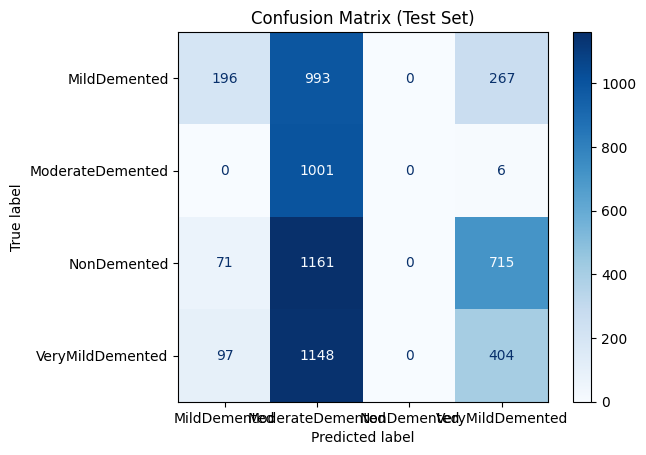


Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.54      0.13      0.22      1456
ModerateDemented       0.23      0.99      0.38      1007
     NonDemented       0.00      0.00      0.00      1947
VeryMildDemented       0.29      0.24      0.27      1649

        accuracy                           0.26      6059
       macro avg       0.27      0.34      0.21      6059
    weighted avg       0.25      0.26      0.19      6059



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Generate predictions
test_images, test_labels = zip(*list(test_dataset.unbatch().as_numpy_iterator()))
test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model_resnet101.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# Print Classification Report
report = classification_report(test_labels, predicted_classes, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

# SVM Model


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Feature extractor using MobileNet
base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract features for SVM
def extract_features_svm(dataset, batch_size=32):
    features, labels = [], []
    for batch in dataset.batch(batch_size):
        images, batch_labels = batch
        batch_features = feature_extractor(images).numpy()
        batch_features_flat = batch_features.reshape(batch_features.shape[0], -1)  # Flatten
        features.append(batch_features_flat)
        labels.append(batch_labels.numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features for train, validation, and test sets
X_train, y_train = extract_features_svm(combined_train)
X_val, y_val = extract_features_svm(combined_val)
X_test, y_test = extract_features_svm(combined_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=300)  # Reduce to 300 dimensions, adjust based on memory constraints
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Train the SVM model
svm_model = SVC(kernel='linear', C=1.0)  # You can experiment with 'rbf' or other kernels
svm_model.fit(X_train_pca, y_train)

# Evaluate the SVM model on the test set
y_pred = svm_model.predict(X_test_pca)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names_original))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# PCA + Random Forest



Preprocessing datasets for PCA and Random Forest with reduced dimensions...

Applying PCA...

Training Random Forest Classifier...

Training Accuracy: 100.00%
Validation Accuracy: 81.41%

Evaluating on the test set...
Test Accuracy: 78.79%

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.73      0.79      0.76      1456
ModerateDemented       0.96      0.70      0.81      1012
     NonDemented       0.81      0.86      0.83      1952
VeryMildDemented       0.74      0.76      0.75      1639

        accuracy                           0.79      6059
       macro avg       0.81      0.78      0.79      6059
    weighted avg       0.80      0.79      0.79      6059



<Figure size 1000x800 with 0 Axes>

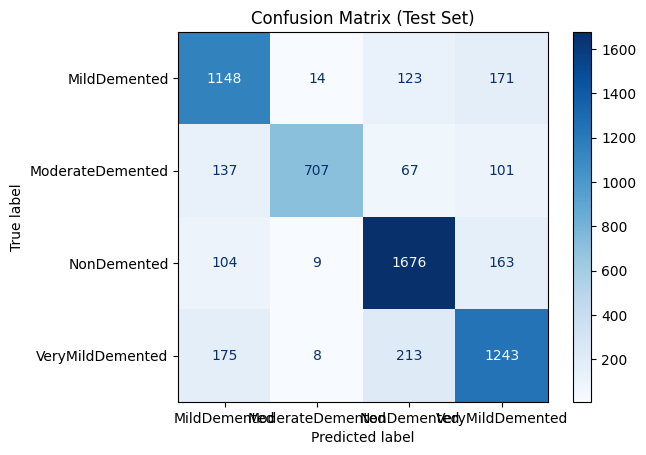

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Preprocess dataset with smaller image size for PCA
def preprocess_for_sklearn_reduced(dataset, img_size=(64, 64)):
    images, labels = zip(*list(dataset.unbatch().as_numpy_iterator()))
    images = np.array(images)
    labels = np.array(labels)
    resized_images = np.array([tf.image.resize(img, img_size).numpy().flatten() for img in images])  # Resize and flatten
    return resized_images, labels

# Preprocess train, validation, and test datasets
print("\nPreprocessing datasets for PCA and Random Forest with reduced dimensions...")
train_images, train_labels = preprocess_for_sklearn_reduced(train_dataset)
val_images, val_labels = preprocess_for_sklearn_reduced(val_dataset)
test_images, test_labels = preprocess_for_sklearn_reduced(test_dataset)

# Apply PCA
print("\nApplying PCA...")
pca = PCA(n_components=0.90, random_state=42)  # Retain 90% variance
train_images_pca = pca.fit_transform(train_images)
val_images_pca = pca.transform(val_images)
test_images_pca = pca.transform(test_images)

# Train Random Forest Classifier
print("\nTraining Random Forest Classifier...")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_images_pca, train_labels)

# Evaluate on training set
train_predictions = rf_classifier.predict(train_images_pca)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on validation set
val_predictions = rf_classifier.predict(val_images_pca)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on test set
print("\nEvaluating on the test set...")
test_predictions = rf_classifier.predict(test_images_pca)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report and confusion matrix
report = classification_report(test_labels, test_predictions, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()


# KNN


Preprocessing datasets for KNN...

Training KNN Classifier...

Training Accuracy: 85.39%
Validation Accuracy: 75.98%

Evaluating on the test set...
Test Accuracy: 75.62%

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.72      0.69      0.71      1464
ModerateDemented       0.70      0.81      0.75       997
     NonDemented       0.79      0.84      0.81      1948
VeryMildDemented       0.79      0.68      0.73      1650

        accuracy                           0.76      6059
       macro avg       0.75      0.76      0.75      6059
    weighted avg       0.76      0.76      0.75      6059



<Figure size 1000x800 with 0 Axes>

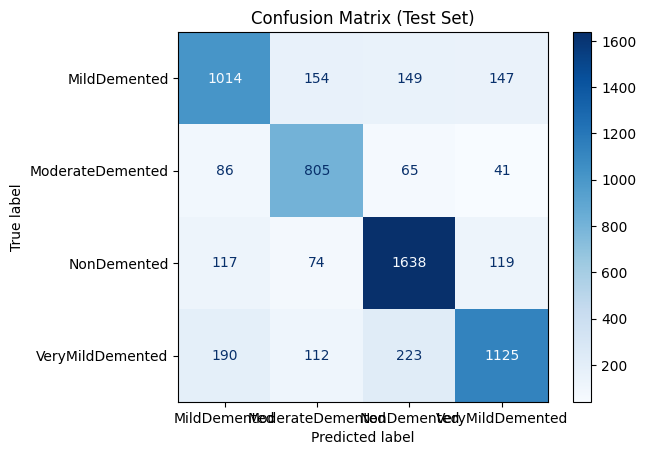

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Preprocess dataset with smaller image size and flatten for KNN
def preprocess_for_sklearn_reduced(dataset, img_size=(128, 128)):
    images, labels = zip(*list(dataset.unbatch().as_numpy_iterator()))
    images = np.array(images)
    labels = np.array(labels)
    resized_images = np.array([tf.image.resize(img, img_size).numpy().flatten() for img in images])  # Resize and flatten
    return resized_images, labels

# Preprocess train, validation, and test datasets
print("\nPreprocessing datasets for KNN...")
train_images, train_labels = preprocess_for_sklearn_reduced(train_dataset)
val_images, val_labels = preprocess_for_sklearn_reduced(val_dataset)
test_images, test_labels = preprocess_for_sklearn_reduced(test_dataset)

# Standardize the data (KNN works better with standardized data)
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
val_images = scaler.transform(val_images)
test_images = scaler.transform(test_images)

# Train KNN Classifier
print("\nTraining KNN Classifier...")
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors
knn_classifier.fit(train_images, train_labels)

# Evaluate on training set
train_predictions = knn_classifier.predict(train_images)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"\nTraining Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on validation set
val_predictions = knn_classifier.predict(val_images)
val_accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluate on test set
print("\nEvaluating on the test set...")
test_predictions = knn_classifier.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report and confusion matrix
report = classification_report(test_labels, test_predictions, target_names=class_names_original)
print("\nClassification Report:\n")
print(report)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_original)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Test Set)')
plt.show()
